In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, log_loss
from sklearn import preprocessing
import sklearn
import os
from matplotlib.pyplot import hist
from scipy import stats
from xgboost import XGBClassifier
from xgboost import XGBRegressor
import pathlib

from austen_plots.AustenPlot import AustenPlot

In [2]:
# set random seed for numpy
RANDOM_SEED=42
np.random.seed(RANDOM_SEED)

In [3]:
# read in the dataframe
oil_df = pd.read_pickle('../Data/data/comprehensive_new_full.pkl')

In [4]:
def att_aiptw(Q0, Q1, g, A, Y, prob_t=None):
    """
    Double ML estimator for the ATT
    This uses the ATT specific scores, see equation 3.9 of https://www.econstor.eu/bitstream/10419/149795/1/869216953.pdf
    Return: aiptw of ATE and its standard error
    """
    
    # number of observations
    n = Y.shape[0]
    
    # estimate marginal probability of treatment
    if prob_t is None:
        prob_t = A.mean() 
    
    # att aiptw
    tau_hat = (A*(Y-Q0) - (1-A)*(g/(1-g))*(Y-Q0)).mean()/ prob_t
  
    # influence curve and standard error of aiptw
    phi = (A*(Y-Q0) - (1-A)*(g/(1-g))*(Y-Q0) - tau_hat*A) / prob_t
    std_hat = np.std(phi) / np.sqrt(n)

    return tau_hat, std_hat

In [5]:
def make_xgboost_g_model():
    return XGBClassifier(n_estimators=50, max_depth=3)

def make_xgboost_Q_model():
    return XGBClassifier(random_state=RANDOM_SEED, n_estimators=500, max_depth=None)

In [6]:
# helper functions to implement the cross fitting

def treatment_k_fold_fit_and_predict(make_model, X:pd.DataFrame, A:np.array, n_splits:int):
    """
    Implements K fold cross-fitting for the model predicting the treatment A. 
    That is, 
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each data point in fold j
    Returns an array containing the predictions  

    Args:
    model: function that returns sklearn model (which implements fit and predict_prob)
    X: dataframe of variables to adjust for
    A: array of treatments
    n_splits: number of splits to use
    """
    predictions = np.full_like(A, np.nan, dtype=float)
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    
    for train_index, test_index in kf.split(X, A):
      X_train = X.loc[train_index]
      A_train = A.loc[train_index]
      g = make_model()
      g.fit(X_train, A_train)

      # get predictions for split
      predictions[test_index] = g.predict_proba(X.loc[test_index])[:, 1]

    assert np.isnan(predictions).sum() == 0
    return predictions


def outcome_k_fold_fit_and_predict(make_model, X:pd.DataFrame, y:np.array, A:np.array, n_splits:int, output_type:str):
    """
    Implements K fold cross-fitting for the model predicting the outcome Y. 
    That is, 
    1. Split data into K folds
    2. For each fold j, the model is fit on the other K-1 folds
    3. The fitted model is used to make predictions for each data point in fold j
    Returns two arrays containing the predictions for all units untreated, all units treated  

    Args:
    model: function that returns sklearn model (that implements fit and either predict_prob or predict)
    X: dataframe of variables to adjust for
    y: array of outcomes
    A: array of treatments
    n_splits: number of splits to use
    output_type: type of outcome, "binary" or "continuous"

    """
    predictions0 = np.full_like(A, np.nan, dtype=float)
    predictions1 = np.full_like(y, np.nan, dtype=float)
    if output_type == 'binary':
      kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)
    elif output_type == 'continuous':
      kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_SEED)

    # include the treatment as input feature
    X_w_treatment = X.copy()
    X_w_treatment["A"] = A

    # for predicting effect under treatment / control status for each data point 
    X0 = X_w_treatment.copy()
    X0["A"] = 0
    X1 = X_w_treatment.copy()
    X1["A"] = 1

    
    for train_index, test_index in kf.split(X_w_treatment, y):
      X_train = X_w_treatment.loc[train_index]
      y_train = y.loc[train_index]
      q = make_model()
      q.fit(X_train, y_train)

      if output_type =='binary':
        predictions0[test_index] = q.predict_proba(X0.loc[test_index])[:, 1]
        predictions1[test_index] = q.predict_proba(X1.loc[test_index])[:, 1]
      elif output_type == 'continuous':
        predictions0[test_index] = q.predict(X0.loc[test_index])
        predictions1[test_index] = q.predict(X1.loc[test_index])

    assert np.isnan(predictions0).sum() == 0
    assert np.isnan(predictions1).sum() == 0
    return predictions0, predictions1

In [7]:
outcome = 'onset2COWCS'
treatment = 'valoilres_binarize'
confounders = ['crude1990P_diff',
               'wildcat_diff',
               'out_regdisaster_diff',
               'ecgrowth',
               'pop_maddison_diff',
               'popdens_diff',
               'democracy_diff',
               'logmountain',
               'ethnic_fractionalization',
               'religion_fractionalization',
               'language_fractionalization',
               'leg_british',
               'decade',
               'opec']

In [8]:
oil_df = oil_df.replace({outcome: .00001}, 0)
oil_df = oil_df[[outcome] + confounders + [treatment]]
oil_df = oil_df.dropna().reset_index()

n = len(oil_df)
outcome = oil_df[outcome]
outcome = outcome.iloc[:, 0]
confounders = oil_df[confounders]
treatment = oil_df[treatment]
treatment = treatment.replace({0.0: 0, 1.0: 1})
outcome = outcome.replace({0.0: 0, 1.0: 1})

In [9]:
confounders = confounders.iloc[:, [0,1,2,3,5,6,7,8,10,12,14,16,18,20]]

In [10]:
g = treatment_k_fold_fit_and_predict(make_xgboost_g_model, X=confounders, A=treatment, n_splits=10)

In [11]:
Q0,Q1=outcome_k_fold_fit_and_predict(make_xgboost_Q_model, X=confounders, y=outcome, A=treatment, n_splits=10, output_type="binary")

In [12]:
data_and_nuisance_estimates = pd.DataFrame({'g': g, 'Q0': Q0, 'Q1': Q1, 'A': treatment, 'Y': outcome})

In [13]:
data_and_nuisance_estimates = data_and_nuisance_estimates[data_and_nuisance_estimates['g'] > .01]
data_and_nuisance_estimates = data_and_nuisance_estimates[data_and_nuisance_estimates['g'] < .99]
print('Dropped {} observations due to overlap condition'.format(len(oil_df) - len(data_and_nuisance_estimates)))

Dropped 1614 observations due to overlap condition


In [14]:
tau_hat, std_hat = att_aiptw(**data_and_nuisance_estimates)

In [15]:
tau_hat

-0.019272429969017086

In [16]:
std_hat

0.02718039142799098

In [17]:
target_bias = 0.02

In [18]:
covariate_groups = {
    'country': ['out_regdisaster_diff',
               'ecgrowth',
               'pop_maddison_diff',
               'popdens_diff',
               'democracy_diff',
               'logmountain',
               'ethnic_fractionalization',
               'religion_fractionalization',
               'language_fractionalization',
               'leg_british'
               ],
    'oilprice': ['crude1990P_diff'],
    'oildiscovery': ['wildcat_diff'],
    'opec': ['opec']}


In [19]:
# For each covariate group, refit the models without using that group
nuisance_estimates = {}
for group, covs in covariate_groups.items():
  remaining_confounders = confounders.drop(columns=covs)

  g = treatment_k_fold_fit_and_predict(make_xgboost_g_model, X=remaining_confounders, A=treatment, n_splits=5)
  Q0, Q1 = outcome_k_fold_fit_and_predict(make_xgboost_Q_model, X=remaining_confounders, y=outcome, A=treatment, n_splits=5, output_type="binary")

  data_and_nuisance_estimates = pd.DataFrame({'g': g, 'Q0': Q0, 'Q1': Q1, 'A': treatment, 'Y': outcome})
  nuisance_estimates[group] = data_and_nuisance_estimates

In [20]:
data_and_nuisance_path = 'data_and_nuisance_estimates.csv'
covariate_dir_path = 'covariates/'

In [21]:
def _convert_to_austen_format(nuisance_estimate_df: pd.DataFrame):
  austen_df = pd.DataFrame()
  austen_df['y']=nuisance_estimate_df['Y']
  austen_df['t']=nuisance_estimate_df['A']
  austen_df['g']=nuisance_estimate_df['g']
  A = nuisance_estimate_df['A']
  austen_df['Q']=A*nuisance_estimate_df['Q1'] + (1-A)*nuisance_estimate_df['Q0'] # use Q1 when A=1, and Q0 when A=0

  return austen_df

In [22]:
austen_data_and_nuisance = _convert_to_austen_format(data_and_nuisance_estimates)
austen_data_and_nuisance.to_csv(data_and_nuisance_path, index=False)

pathlib.Path(covariate_dir_path).mkdir(exist_ok=True)
for group, nuisance_estimate in nuisance_estimates.items():
  austen_nuisance_estimate = _convert_to_austen_format(nuisance_estimate)
  austen_nuisance_estimate.to_csv(os.path.join(covariate_dir_path,group+".csv"), index=False)

In [23]:
ap = AustenPlot(data_and_nuisance_path, covariate_dir_path)

In [24]:
p, plot_coords, variable_coords = ap.fit(bias=target_bias)

Fitting main dataset


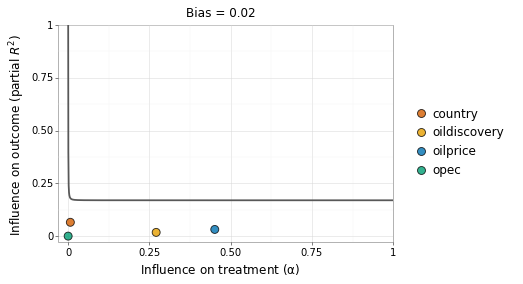

<ggplot: (-9223371879778275976)>

In [25]:
p